In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.integrate import simpson
from tqdm import tqdm

In [2]:
common_settings = {
'perturbations_verbose':0,
'background_verbose':1,
'output':'mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':300,
'z_max_pk':1000,
'format':'class'
}

f_chi = 0.0178352 #SenZald uses this
aNR  = 2.3e-3 #SenZald uses this
chiCDM = Class()
# pass input parameters
chiCDM.set(common_settings)
chiCDM.set({
'h':0.688,
'A_s': 2.187e-9,

'omega_cdm':0.115,
# 'f_chi':f_chi ,
# 'acs_chi':aNR,
# 'cs2_peak_chi':1./3.,
# 'N_ur': 2.0328,
# 'N_ncdm':1,
# 'm_ncdm':0.1, #0.1 means 0.8%


})

chiCDM.compute()

Running CLASS version v3.2.0
Computing background
 -> age = 13.804705 Gyr
 -> conformal age = 14290.517525 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3299.377483
    corresponding to conformal time = 116.356045 Mpc


In [3]:
from scipy.interpolate import interp1d
fact=(2*np.pi)**3

kk = np.logspace(-5,np.log10(200),500) # k in h/Mpc
Pkchi = [] # P(k) in (Mpc/h)**3
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc

lowz=0.

for k in kk:
    Pkchi.append(chiCDM.pk_lin(k*h,lowz)*h**3) # function .pk(k,z)
Pkchi=np.array(Pkchi)

Pchi_int = interp1d(kk, Pkchi, fill_value='extrapolate')


# plt.figure(figsize=(4,3), dpi=130)
# plt.xscale('log');plt.yscale('log');
# plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
# plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
# plt.plot(kk,Pkchi,'r-',label=r'ChiCDM')
# plt.plot(kk[:-1]+1.e-3,Pchi_int(kk[:-1]+1.e-3),'c-',label=r'txt')
# plt.legend()
# plt.show()

---
### Compute looop

In [4]:
def F2(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)

def DeltaF2(mu):
    mu2=mu*mu
    return 6/245*(1-mu2)

def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)
    return res1+res2


def DeltaF3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 

    res1 = 1/kMq2*(-88/945*k2-28/405*k*q*mu+128/2835*k2*k*mu/q+92/567*k2*mu2-128/2835*k2*k*mu2*mu/q)
    res2 = 1/kMq2*(28/405*q*k*mu2*mu-28/405*k2*mu2*mu2)

    return res1+res2

In [12]:
klist=np.logspace(-2,0,100)
# klist=[0.1]
onelterm=[]
eps=1.e-4
fx=0.

for i in tqdm(range(len(klist)), desc="Processing modes", unit="iter"):
    k=klist[i]
    # print('k='+str(k))
    qq = np.logspace(np.log10(eps),np.log10(5),300)
    intgndq = np.zeros_like(qq)
    for i in range(len(qq)):
        q = qq[i]
        muu= np.linspace(-1.,1., 200) #occhio questo e un vettore eh
        F3_val = F3(k,q,muu)-fx/7*DeltaF3(k,q,muu)
        # F3_val = 0.1/7*DeltaF3(k,q,muu)

        intgndmu = 6*q*q*F3_val*Pchi_int(q)*Pchi_int(k) #13 part


        kMq = np.sqrt(k*k + q*q - 2*k*q*muu)
        mumask = kMq>q
        F2_val = F2(k,q,muu)+fx*DeltaF2(muu)
        tmp22 = 2*q*q*F2_val*F2_val*Pchi_int(q)*Pchi_int(kMq)
        tmp22[~mumask] = 0
        intgndmu += tmp22

        kPq = np.sqrt(k*k + q*q + 2*k*q*muu) #22 part
        mumask = kPq>q
        F2_val = F2(k,q,-muu)+fx*DeltaF2(-muu)
        tmp22 = 2*q*q*F2_val*F2_val*Pchi_int(q)*Pchi_int(kPq)
        tmp22[~mumask] = 0
        intgndmu += tmp22

        muintegral = simpson(intgndmu,muu)
        intgndq[i]=muintegral

    pintegral = simpson(intgndq,qq)*(2*np.pi)/fact
    onelterm.append(pintegral)
onelterm_EdS=np.array(onelterm)


Processing modes: 100%|██████████| 100/100 [00:14<00:00,  6.92iter/s]


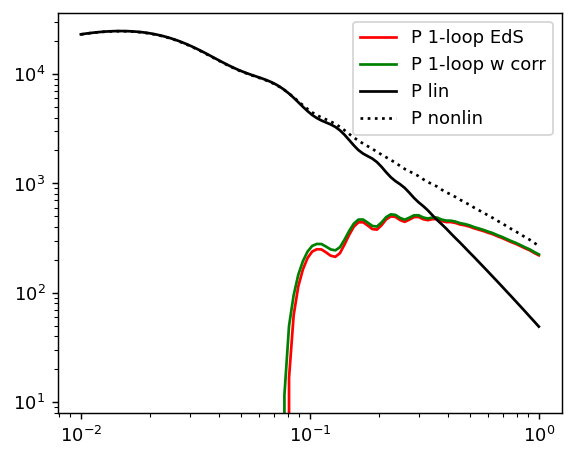

In [13]:
plt.figure(figsize=(5,4), dpi=130)

plt.plot(klist,onelterm_EdS, 'r',label=r'P 1-loop EdS')
plt.plot(klist,onelterm_withcorr, 'g',label=r'P 1-loop w corr')

qq = np.logspace(-2,0,100) 

plt.plot(qq,Pchi_int(qq),'k',label=r'P lin')
plt.plot(klist,Pchi_int(klist)+onelterm,'k:',label=r'P nonlin')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

---
plot with relativr difference

parallelized

In [14]:
import concurrent.futures

klist=np.logspace(-2,0,200)
# klist=[0.1]
# onelterm=np.zeros_like(klist)
eps=1.e-4
f_chi = 0.0178352 #SenZald uses this
# logenh = 12/5*f_chi*np.log(1/2.93e-4)
# f_chi=0
logenh=1
def eval_one_loop(k):
    i=np.where(klist == k)
    # print('k='+str(k))
    qq = np.logspace(np.log10(eps),np.log10(5),300)
    intgndq = np.zeros_like(qq)
    for i in range(len(qq)):
        q = qq[i]
        muu= np.linspace(-1.,1., 200) #occhio questo e un vettore eh
        F3_val = F3(k,q,muu)-f_chi/7*DeltaF3(k,q,muu)
        # F3_val = 0.1/7*DeltaF3(k,q,muu)

        intgndmu = 6*q*q*F3_val*Pchi_int(q)*Pchi_int(k)*(logenh) #13 part


        kMq = np.sqrt(k*k + q*q - 2*k*q*muu)
        mumask = kMq>q
        F2_val = F2(k,q,muu)+f_chi*DeltaF2(muu)
        tmp22 = 2*q*q*F2_val*F2_val*Pchi_int(q)*Pchi_int(kMq)
        tmp22[~mumask] = 0
        intgndmu += tmp22*(logenh)

        kPq = np.sqrt(k*k + q*q + 2*k*q*muu) #22 part
        mumask = kPq>q
        F2_val = F2(k,q,-muu)+f_chi*DeltaF2(-muu)
        tmp22 = 2*q*q*F2_val*F2_val*Pchi_int(q)*Pchi_int(kPq)
        tmp22[~mumask] = 0
        intgndmu += tmp22*(logenh)

        muintegral = simpson(intgndmu,muu)
        intgndq[i]=muintegral

    pintegral = simpson(intgndq,qq)*(2*np.pi)/fact
    return(pintegral)

with concurrent.futures.ProcessPoolExecutor() as executor:
    onelterm = executor.map(eval_one_loop, klist)
    
onelterm_withcorr = np.array(list(onelterm))

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [3,1]}, figsize=(4.5,5), dpi=130)
plt.subplots_adjust(hspace = 0)

axs[0].plot(klist,Pchi_int(klist),'k',label=r'$P_{lin}$', linewidth=1.2)
axs[0].plot(klist,np.abs(onelterm_EdS), 'b',label=r'$|_{1-loop}|$, EdS ker', linewidth=1.2)
axs[0].plot(klist,np.abs(onelterm_withcorr), 'r',label=r'$|_{1-loop}|$, new ker', linewidth=1.2)
axs[0].plot(klist,Pchi_int(klist)+onelterm_EdS,'b--',label=r'$P_{NL}$, EdS ker', linewidth=1.2)
axs[0].plot(klist,Pchi_int(klist)+onelterm_withcorr,'--', color='r',label=r'$P_{NL}$, new ker', linewidth=1.2)


axs[1].loglog(klist,np.abs(onelterm_EdS/onelterm_withcorr-1), 'indigo', label='1 loop rel diff', linewidth=1.)
axs[1].loglog(klist,np.abs((Pchi_int(klist)+onelterm_EdS)/(Pchi_int(klist)+onelterm_withcorr)-1), 'indigo', linestyle='--', label='NL rel diff', linewidth=1.)


axs[0].legend(loc='best')
axs[0].set_xlim([1.e-2,1])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xlabel('k')
axs[0].set_title(r'$P_c^{\mathrm{1loop}}$ with new kernels, $f_\chi = '+str(int(f_chi*100))+'\%$')
axs[1].legend(loc='upper left', fontsize=9)
axs[1].set_ylim([1.e-3,1])
axs[0].set_ylim([1.e0,4.e4])

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/kercompare-fx03.pdf',bbox_inches='tight')

plt.show()

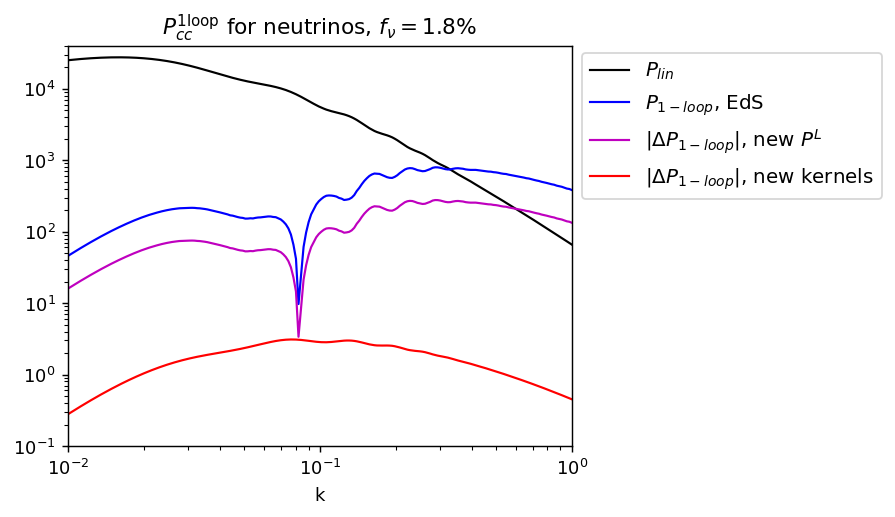

In [25]:
plt.figure(figsize=(5,4), dpi=130)

plt.plot(klist,Pchi_int(klist),'k',label=r'$P_{lin}$', linewidth=1.2)
plt.plot(klist,np.abs(onelterm_EdS), 'b',label=r'$P_{1-loop}$, EdS', linewidth=1.2)
plt.plot(klist,np.abs(onelterm_logenh), 'm',label=r'$|\Delta P_{1-loop}|$, new $P^L$', linewidth=1.2)

plt.plot(klist,np.abs(onelterm_withcorr-onelterm_EdS), 'r',label=r'$|\Delta P_{1-loop}|$, new kernels', linewidth=1.2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=11)
plt.xlim([1.e-2,1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.title(r'$P_{cc}^{\mathrm{1loop}}$ for neutrinos, $f_\nu = 1.8\%$')
plt.ylim([1.e-1,4.e4])

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/P1loop-contribs-nu-4pr.pdf',bbox_inches='tight')

plt.show()

In [85]:
f_chi = 0.0178352 #SenZald uses this
logenh = 12/5*f_chi*np.log(1/2.93e-4)
print(logenh/f_chi)
print(16+16*0.3)

19.524811077473295
20.8
